### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [1]:
# You will need to download any word embeddings required for your code, e.g.:

#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip
!pip install transformers
# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

#! pip install torch

     |████████████████████████████████| 1.8MB 14.4MB/s 
     |████████████████████████████████| 890kB 27.1MB/s 
     |████████████████████████████████| 3.2MB 50.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=6fbc5432223a213b53a4dcd12c3e97fba63d53a26845d71f8c668bd36f68cb5a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Imports

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs
import transformers
from keras.preprocessing.sequence import pad_sequences

In [4]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [6]:
# Load data
train_df = pd.read_csv('./drive/MyDrive/NLP_CW/train.csv')
dev_df = pd.read_csv('./drive/MyDrive/NLP_CW/dev.csv')
test_df = pd.read_csv('./drive/MyDrive/NLP_CW/test.csv')

In [7]:
# Number of epochs
epochs = 10

# Proportion of training data for train compared to dev
train_proportion = 0.8

# batch_size
BATCH_SIZE = 32

In [8]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, method=None):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    
    print("Training model.")
    if method == 'bert':
        train_loss = []
        eval_loss = []

        for epoch in range(1, number_epoch+1):
            model.train()
            epoch_loss = 0
            epoch_sse = 0
            no_observations = 0

            for batch in train_iter:
                feature, target, mask = batch
                
                feature, target, mask = feature.to(device), target.to(device), mask.to(device)
                model.batch_size = target.shape[0]
                no_observations += target.shape[0]
                output = model(feature, attention_mask=mask, labels=target)
                predictions = output.logits.squeeze(1)

                optimizer.zero_grad()
                loss = loss_fn(predictions, target)

                sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()*target.shape[0]
                epoch_sse += sse
            
            valid_loss, valid_mse, __, __ = eval(dev_iter, model, method=method)

            epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
            
            train_loss += [epoch_loss]
            eval_loss += [valid_loss]
            
            print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
            Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')
        torch.save(model.state_dict(), './drive/MyDrive/NLP_CW/bert.pth')
        np.save('./drive/MyDrive/NLP_CW/train_loss.npy', train_loss)
        np.save('./drive/MyDrive/NLP_CW/eval_loss.npy', eval_loss)
    else:
        for epoch in range(1, number_epoch+1):

            model.train()
            epoch_loss = 0
            epoch_sse = 0
            no_observations = 0  # Observations used for training so far

            for batch in train_iter:

                feature, target = batch

                feature, target = feature.to(device), target.to(device)

            # for RNN:
                model.batch_size = target.shape[0]
                no_observations = no_observations + target.shape[0]
                model.hidden = model.init_hidden()

                predictions = model(feature).squeeze(1)

                optimizer.zero_grad()

                loss = loss_fn(predictions, target)

                sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()*target.shape[0]
                epoch_sse += sse

            valid_loss, valid_mse, __, __ = eval(dev_iter, model)

            epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
            print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
            Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

In [9]:
# We evaluate performance on our dev set
def eval(data_iter, model, method=None):
    """
    Evaluating model performance on the dev set
    """
    if method == 'bert':
        model.eval()
        epoch_loss = 0
        epoch_sse = 0
        pred_all = []
        trg_all = []
        no_observations = 0

        with torch.no_grad():
            for batch in data_iter:
                feature, target, mask = batch

                feature, target, mask = feature.to(device), target.to(device), mask.to(device)

            # for RNN:
                model.batch_size = target.shape[0]
                no_observations = no_observations + target.shape[0]
                output = model(feature, attention_mask=mask, labels=target)
                predictions = output.logits.squeeze(1)

                loss = loss_fn(predictions, target)

            # We get the mse
                pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
                sse, __ = model_performance(pred, trg)

                epoch_loss += loss.item()*target.shape[0]
                epoch_sse += sse
                pred_all.extend(pred)
                trg_all.extend(trg)
    
    else:
        model.eval()
        epoch_loss = 0
        epoch_sse = 0
        pred_all = []
        trg_all = []
        no_observations = 0

        with torch.no_grad():
            for batch in data_iter:
                feature, target = batch

                feature, target = feature.to(device), target.to(device)

            # for RNN:
                model.batch_size = target.shape[0]
                no_observations = no_observations + target.shape[0]
                model.hidden = model.init_hidden()

                predictions = model(feature).squeeze(1)
                loss = loss_fn(predictions, target)

            # We get the mse
                pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
                sse, __ = model_performance(pred, trg)

                epoch_loss += loss.item()*target.shape[0]
                epoch_sse += sse
                pred_all.extend(pred)
                trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [10]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [11]:
def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list

    for sentence in data:

        tokenized_sentence = []

        for token in sentence.split(' '): # simplest split is

            tokenized_sentence.append(token)

        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

In [12]:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''

    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    batch_features_len = [len(f) for f, l in batch]

    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels

class Task1DatasetBert(Dataset):

    def __init__(self, train_data, labels, mask):
        self.x_train = train_data
        self.y_train = labels
        self.mask = mask

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item], self.mask[item]

class Task1Dataset(Dataset):

    def __init__(self, train_data, labels, mask):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

In [ ]:
class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, embedding, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2)

        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)

        out = self.hidden2label(lstm_out[-1])
        return out

# Part 1 Second Experiment

In [20]:
MaxLen = 40


def create_dataloader(df):
    data = df['original']
    model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased')

    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    data_tokenized = data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    data_tokenized = pad_sequences(data_tokenized, maxlen=MaxLen, dtype='long', value=0, truncating='post')
    print('setence tokenized and padded.')
    attention_mask = []
    for token in data_tokenized:
        att_mask = [int(token_id > 0) for token_id in token]
        attention_mask.append(att_mask)

    data_tokenized = torch.tensor(data_tokenized)
    label = torch.tensor(df['meanGrade'], dtype=torch.float32)
    attention_mask = torch.tensor(attention_mask, dtype=torch.int32)
    dataset = Task1DatasetBert(data_tokenized, label, attention_mask)
    loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)
    print('data loader created.')
    return loader

train_loader = create_dataloader(train_df)
dev_loader = create_dataloader(dev_df)
test_loader = create_dataloader(test_df)

model = transformers.BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                                   num_labels=1,
                                                                   output_attentions=False,
                                                                   output_hidden_states=False)
model.hidden_dropout_prob = 0.3
model.attention_dropout_prob = 0.3
model.cuda()

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=0.03)

train(train_loader, dev_loader, model, epochs, 'bert')


setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.
setence tokenized and padded.
data loader created.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training model.
| Epoch: 01 | Train Loss: 0.37 | Train MSE: 0.37 | Train RMSE: 0.60 |             Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 02 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |             Val. Loss: 0.38 | Val. MSE: 0.38 |  Val. RMSE: 0.61 |
| Epoch: 03 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |             Val. Loss: 0.40 | Val. MSE: 0.40 |  Val. RMSE: 0.63 |
| Epoch: 04 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |             Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 05 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |             Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 06 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |             Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.60 |
| Epoch: 07 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |             Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 08 | Train Loss: 0.36 |

In [21]:
test_loss, test_mse, __, __ = eval(test_loader, model, 'bert')
print(test_loss, test_mse)

0.35121269153539464 0.35121268948549944


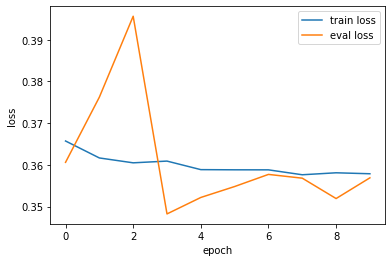

In [22]:
# draw training curve
import matplotlib.pyplot as plt
plt.figure()
train_loss = np.load('./drive/MyDrive/NLP_CW/train_loss.npy')
eval_loss = np.load('./drive/MyDrive/NLP_CW/eval_loss.npy')
x = list(range(len(train_loss)))
plt.plot(x, train_loss)
plt.plot(x, eval_loss)
plt.legend(['train loss', 'eval loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


#### Approach 2: No pre-trained representations

In [ ]:
train_and_dev = train_df['edit']

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.13 | RMSE: 0.37 |

Dev performance:
| MSE: 0.36 | RMSE: 0.60 |


#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)


Baseline performance:
| MSE: 0.34 | RMSE: 0.58 |
